In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Data imports

In [41]:
# read data for cMedupi
data_for_model = pd.read_csv(r'C:\Users\Shivm\Documents\Masters\Research Project\Eskom air quality data\Eskom Model\PM2.5 Models\Combined Station Data.csv')
#data_for_model.drop(columns=['anomaly'], inplace=True)
data_for_model = data_for_model[data_for_model['Location_Medupi']==True]
data_for_model['NO1'] = data_for_model['NO1'].fillna(data_for_model['NOX'] - data_for_model['NO2'])

data_for_model

,Date,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend
89341,2015/01/01 00:00:00,2.130139,76.13343,0.068,3.463,4.077,NaN,2.068059,0.510513,NaN,913.0,NaN,0.614,2015-01-01 00:00:00,0.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.130139,NaN,2.130139,NaN,2.130139,NaN,2.130139,NaN,76.133430,NaN,76.133430,NaN,76.133430,NaN,76.133430,NaN,0.068000,NaN,0.068000,NaN,0.068000,NaN,0.068000,NaN,3.463000,NaN,3.463000,NaN,3.463000,NaN,3.463000,NaN,4.077000,NaN,4.077000,NaN,4.077000,NaN,4.077000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.068059,NaN,2.068059,NaN,2.068059,NaN,2.068059,NaN,0.510513,NaN,0.510513,NaN,0.510513,NaN,0.510513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,913.000000,NaN,913.0,NaN,913.000000,NaN,913.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,False,False,True,False,True,False
89342,2015/01/01 01:00:00,1.301876,106.78110,0.051,3.724,4.377,NaN,1.246435,-0.375872,NaN,913.0,NaN,0.653,2015-01-01 01:00:00,1.0,1.0,3.0,2.130139,76.13343,0.068,3.463,4.077,NaN,2.068059,0.510513,NaN,913.0,NaN,NaN,1.716007,0.585670,1.716007,0.585670,1.716007,0.585670,1.716007,0.585670,91.457265,21.671175,91.457265,21.671175,91.457265,21.671175,91.457265,21.671175,0.059500,0.012021,0.059500,0.012021,0.059500,0.012021,0.059500,0.012021,3.593500,0.184555,3.593500,0.184555,3.593500,0.184555,3.593500,0.184555,4.227000,0.212132,4.227000,0.212132,4.227000,0.212132,4.227000,0.212132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.657247,0.580976,1.657247,0.580976,1.657247,0.580976,1.657247,0.580976,0.067320,0.626769,0.067320,0.626769,0.067320,0.626769,0.067320,0.626769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,913.000000,0.00000,913.0,0.000000,913.000000,0.000000,913.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,False,False,True,False,True,False
89343,2015/01/01 02:00:00,1.280043,105.14610,0.060,3.694,4.583,NaN,1.235578,-0.334451,NaN,913.0,NaN,0.889,2015-01-01 02:00:00,2.0,1.0,

In [42]:
#null checks
data_for_model.isna().sum()

Date                  1
Wind                907
Wind Dir            932
SO2                2508
NO2                6899
                   ... 
Season_Spring         0
Season_Summer         0
Season_Winter         0
DayType_Weekday       0
DayType_Weekend       0
Length: 138, dtype: int64

In [43]:
data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
data_for_model['Year'] = data_for_model['Date Time'].dt.year
data_for_model.drop(columns=['Date', 'Date Time'], inplace=True)


In [44]:
data_for_model.shape

(81035, 137)

## Create Target variable and rolling features

In [45]:
data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
data_for_model['PM2.5_lag2'] = data_for_model['PM2.5'].shift(2)
data_for_model['PM2.5_lag3'] = data_for_model['PM2.5'].shift(3)
data_for_model['PM2.5_t+1'] = data_for_model['PM2.5'].shift(-1)


# Rolling means with different windows, shifted by 1 to prevent leakage
data_for_model['PM2.5_diff1'] = data_for_model['PM2.5'] - data_for_model['PM2.5'].shift(1)
#data_for_model['Temp_diff1'] = data_for_model['Temp'] - data_for_model['Temp'].shift(1)

data_for_model = data_for_model.drop(columns=[col for col in data_for_model.columns if 'Temp' in col or 'NO1' in col])

data_for_model = data_for_model.dropna().reset_index(drop=True)
# # # Split by year
df_train = data_for_model[data_for_model['Year'] == 2015]
df_test = data_for_model[data_for_model['Year'] == 2016]
df_val = data_for_model[data_for_model['Year'] == 2017]


In [46]:
data_for_model.isna().sum()

Wind           0
Wind Dir       0
SO2            0
NO2            0
NOX            0
              ..
Year           0
PM2.5_lag2     0
PM2.5_lag3     0
PM2.5_t+1      0
PM2.5_diff1    0
Length: 121, dtype: int64

In [47]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_lag2,PM2.5_lag3,PM2.5_t+1,PM2.5_diff1
0,2.490343,234.7847,4.427,6.703,12.490,5.389,-2.034588,-1.436058,14.120,907.0,14.0,10.0,3.0,2.501450,249.6231,4.495,6.873,13.180,1.787,-2.344915,-0.870990,13.950,908.0,2.330113,0.287199,2.201978,0.296242,2.039394,0.366979,2.353164,0.502630,259.544333,30.937298,274.519783,27.858790,268.741976,89.465901,185.028421,148.995371,4.502667,0.079777,6.646400,4.567414,6.175571,3.836787,35.083000,54.819578,6.788000,0.120208,6.788000,0.120208,7.731800,0.995371,11.608176,5.420308,12.835000,0.487904,12.835000,0.487904,11.398000,1.468526,27.825294,16.160745,2.473000,2.640696,1.338667,2.081675,9.691750,11.785948,6.332375,9.923860,-2.067352,0.262717,-1.973031,0.219098,-1.524511,0.716274,-0.488650,1.242491,-0.495665,1.173950,0.116605,1.081882,0.738160,1.014406,1.641148,1.194721,14.240000,0.365103,14.375000,0.275082,14.640909,0.383052,14.640909,0.383052,907.666667,0.57735,907.833333,0.408248,908.333333,0.651339,909.291667,1.197068,False,False,False,False,False,True,False,False,True,False,False,True,False,2015.0,14.650,14.490,14.080,0.170
1,2.615783,221.1015,4.484,11.510,20.190,11.270,-1.719603,-1.971113,14.080,907.0,14.0,10.0,3.0,2.490343,234.7847,4.427,6.703,12.490,5.389,-2.034588,-1.436058,14.120,907.0,2.535859,0.069439,2.348570,0.229860,2.099487,0.398788,2.353402,0.502758,235.169767,14.264699,266.467167,35.549880,258.260893,86.808205,193.263973,145.087172,4.468667,0.036501,6.286000,4.179515,6.001000,3.889155,31.783474,54.667125,8.362000,2.727573,8.362000,2.727573,8.259800,1.971575,11.182294,5.098997,15.286667,4.260403,15.286667,4.260403,13.238000,4.148225,26.113529,15.261198,6.148667,4.786924,3.182167,4.441422,9.037583,11.427471,6.794667,9.882894,-2.033035,0.312659,-1.970274,0.222748,-1.631957,0.628538,-0.603576,1.222485,-1.426054,0.550130,-0.208970,1.382526,0.420137,1.214318,1.459246,1.391214,14.050000,0.088882,14.296667,0.282111,14.594167,0.399510,14.594167,0.399510,907.333333,0.57735,907.666667,0.516398,908.166667,0.717741,909.125000,1.226962,False,False,False,False,False,True,False,False,True,False,False,True,False,2015.0,13.950,14.650,13.790,-0.040
2,3.527183,230.7325,4.223,23.680,41.750,15.580,-2.730743,-2.232502,13.790,907.0,14.0,10.0,3.0,2.615783,221.1015,4.4

## Correlation Matrix to identify best features

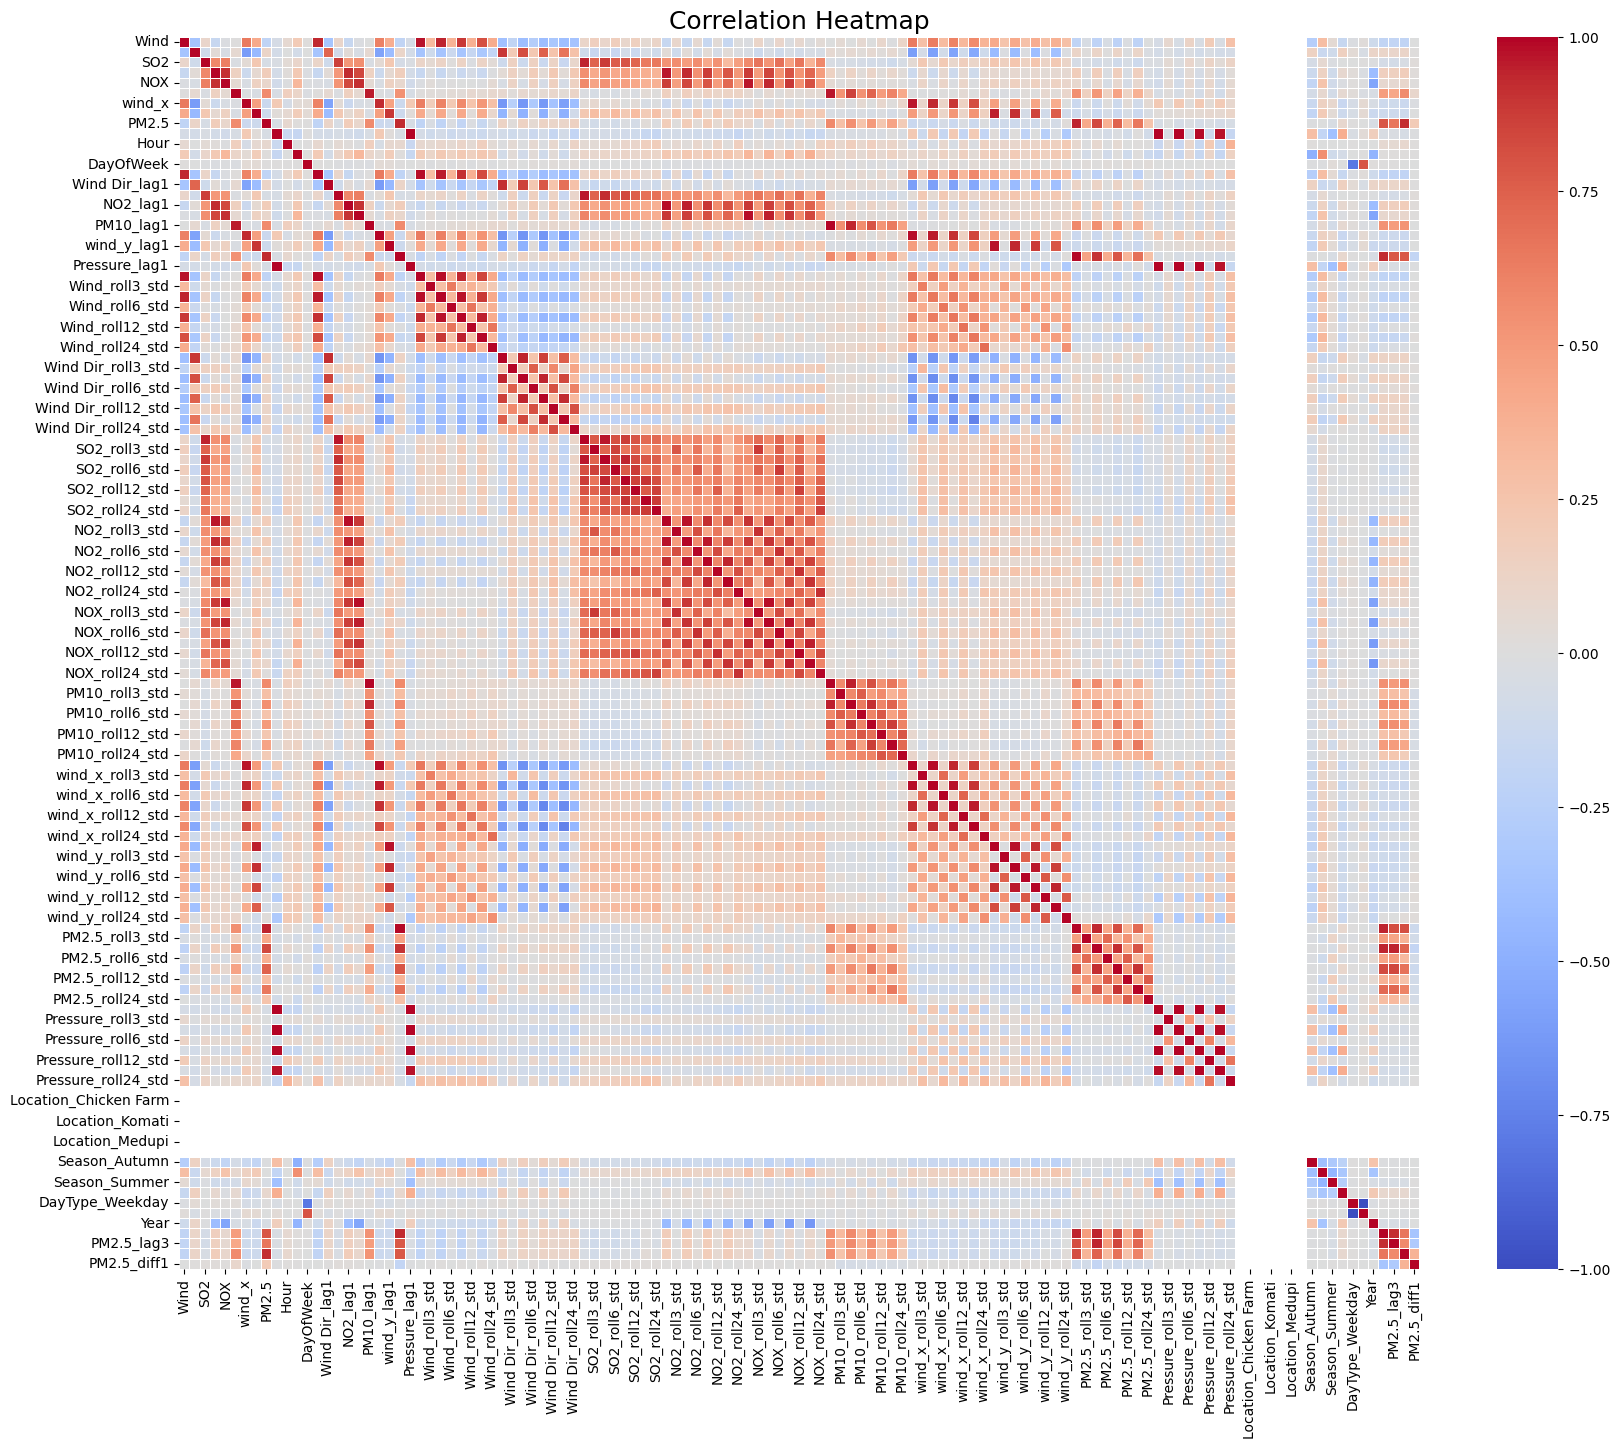

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_for_model.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Heatmap', fontsize=18)
plt.show()


In [51]:
# Compute correlations with the target
target = 'PM2.5_t+1'
correlations = data_for_model.corr()[target].drop(target)

# Sort by absolute correlation (strongest relationships first)
feature_ranking = correlations.abs().sort_values(ascending=False)

# Display top 15 features most correlated with PM2.5_t+12
print("Top correlated features with PM2.5_t+1:\n")
print(feature_ranking.head(20))

Top correlated features with PM2.5_t+1:

PM2.5                0.916986
PM2.5_roll3_mean     0.819142
PM2.5_lag1           0.779801
PM2.5_roll6_mean     0.737220
PM2.5_roll12_mean    0.677045
PM2.5_lag2           0.658946
PM2.5_roll24_mean    0.607673
PM2.5_lag3           0.570943
PM10                 0.563986
PM10_roll3_mean      0.539682
PM10_lag1            0.528584
PM10_roll6_mean      0.506237
PM10_roll12_mean     0.465596
PM10_roll24_mean     0.425091
PM2.5_diff1          0.360997
PM2.5_roll3_std      0.357917
PM2.5_roll6_std      0.312647
PM2.5_roll12_std     0.258512
PM10_roll3_std       0.254341
PM10_roll6_std       0.233051
Name: PM2.5_t+1, dtype: float64


In [52]:
feature_ranking

PM2.5                 0.916986
PM2.5_roll3_mean      0.819142
PM2.5_lag1            0.779801
PM2.5_roll6_mean      0.737220
PM2.5_roll12_mean     0.677045
                        ...   
Location_Grootvlei         NaN
Location_Komati            NaN
Location_Marapong          NaN
Location_Medupi            NaN
Location_Phola             NaN
Name: PM2.5_t+1, Length: 120, dtype: float64

In [53]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_lag2,PM2.5_lag3,PM2.5_t+1,PM2.5_diff1
0,2.490343,234.7847,4.427,6.703,12.490,5.389,-2.034588,-1.436058,14.120,907.0,14.0,10.0,3.0,2.501450,249.6231,4.495,6.873,13.180,1.787,-2.344915,-0.870990,13.950,908.0,2.330113,0.287199,2.201978,0.296242,2.039394,0.366979,2.353164,0.502630,259.544333,30.937298,274.519783,27.858790,268.741976,89.465901,185.028421,148.995371,4.502667,0.079777,6.646400,4.567414,6.175571,3.836787,35.083000,54.819578,6.788000,0.120208,6.788000,0.120208,7.731800,0.995371,11.608176,5.420308,12.835000,0.487904,12.835000,0.487904,11.398000,1.468526,27.825294,16.160745,2.473000,2.640696,1.338667,2.081675,9.691750,11.785948,6.332375,9.923860,-2.067352,0.262717,-1.973031,0.219098,-1.524511,0.716274,-0.488650,1.242491,-0.495665,1.173950,0.116605,1.081882,0.738160,1.014406,1.641148,1.194721,14.240000,0.365103,14.375000,0.275082,14.640909,0.383052,14.640909,0.383052,907.666667,0.57735,907.833333,0.408248,908.333333,0.651339,909.291667,1.197068,False,False,False,False,False,True,False,False,True,False,False,True,False,2015.0,14.650,14.490,14.080,0.170
1,2.615783,221.1015,4.484,11.510,20.190,11.270,-1.719603,-1.971113,14.080,907.0,14.0,10.0,3.0,2.490343,234.7847,4.427,6.703,12.490,5.389,-2.034588,-1.436058,14.120,907.0,2.535859,0.069439,2.348570,0.229860,2.099487,0.398788,2.353402,0.502758,235.169767,14.264699,266.467167,35.549880,258.260893,86.808205,193.263973,145.087172,4.468667,0.036501,6.286000,4.179515,6.001000,3.889155,31.783474,54.667125,8.362000,2.727573,8.362000,2.727573,8.259800,1.971575,11.182294,5.098997,15.286667,4.260403,15.286667,4.260403,13.238000,4.148225,26.113529,15.261198,6.148667,4.786924,3.182167,4.441422,9.037583,11.427471,6.794667,9.882894,-2.033035,0.312659,-1.970274,0.222748,-1.631957,0.628538,-0.603576,1.222485,-1.426054,0.550130,-0.208970,1.382526,0.420137,1.214318,1.459246,1.391214,14.050000,0.088882,14.296667,0.282111,14.594167,0.399510,14.594167,0.399510,907.333333,0.57735,907.666667,0.516398,908.166667,0.717741,909.125000,1.226962,False,False,False,False,False,True,False,False,True,False,False,True,False,2015.0,13.950,14.650,13.790,-0.040
2,3.527183,230.7325,4.223,23.680,41.750,15.580,-2.730743,-2.232502,13.790,907.0,14.0,10.0,3.0,2.615783,221.1015,4.4

## Feature Selection

In [ ]:
features = feature_ranking.head(20).index.tolist()



In [55]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+1'], df_test['PM2.5_t+1']])#data_for_model['PM2.5_t+1']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [56]:
y

0        14.080
1        13.790
2        14.530
3        14.740
4        14.800
          ...  
10955     9.550
10956    10.180
10957    14.610
10958    14.560
10959     7.511
Name: PM2.5_t+1, Length: 10960, dtype: float64

## Data splitting for models

In [57]:
# Let's use 80% of the data for training, 20% for testing
split_idx = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


## LSTM Model (Neural Network)

In [58]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 280.3791 - val_loss: 34.9066
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 17.2925 - val_loss: 21.5241
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 11.3692 - val_loss: 14.5281
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 8.6395 - val_loss: 13.2660
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 7.5717 - val_loss: 12.3610
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 6.9785 - val_loss: 12.0935
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0641 - val_loss: 12.2099
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 7.1499 - val_loss: 11.7314
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7723 - val_loss: 11.6369
Epoch 10/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 6.9606 - val_loss: 11.9409
Epoch 11/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7114 - val_loss: 11.8369
Epoch 12/50
274/274 ━━━

In [59]:
#Prediction accuracy
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R²: 0.94451487316247
RMSE: 3.3749919803866066


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [60]:
#Validation data prediction
X_val = df_val[features]
y_val = df_val['PM2.5_t+1']

X_val_scaled = scaler.fit_transform(X_val)


y_pred_val = model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")

1362/1362 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step
R²: 0.8207603045426498
RMSE: 6.126390366707244


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [61]:
last_known_data = data_for_model.iloc[-1][features].values.reshape(1, -1)
last_known_data_scaled = scaler.transform(last_known_data)

forecast_3hr = model.predict(last_known_data_scaled)[0][0]
print(f"Forecasted PM2.5 (3 hrs ahead): {forecast_3hr}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Forecasted PM2.5 (3 hrs ahead): 8.663797378540039


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


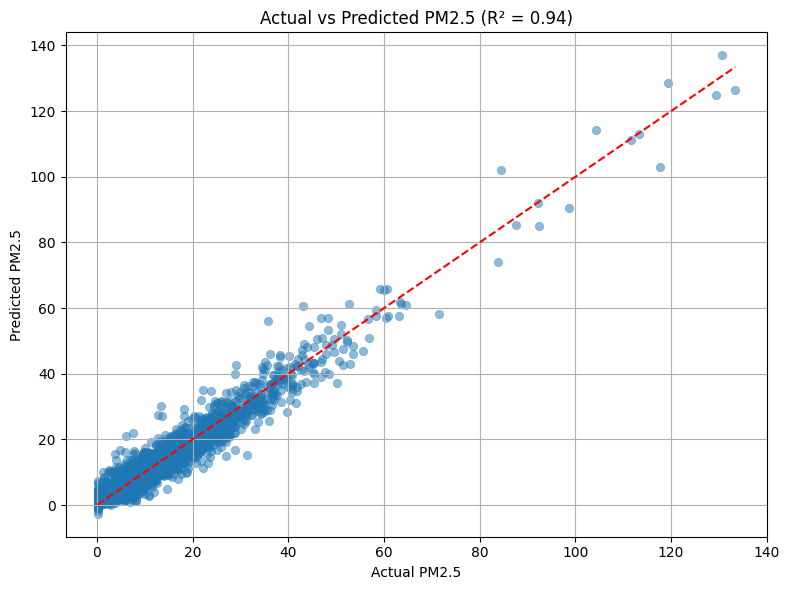

In [62]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Actual vs Predicted PM2.5 (R² = {r2_score(y_test, y_pred):.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [63]:
y_val

10960     7.715
10961    11.310
10962    15.700
10963    19.650
10964    16.370
          ...  
54533     4.055
54534     8.122
54535     9.364
54536     8.864
54537     9.494
Name: PM2.5_t+1, Length: 43578, dtype: float64

# Testing out XGBoost Regressor and Random Forrest Regressor

In [64]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+1'], df_test['PM2.5_t+1']])#data_for_model['PM2.5_t+1']

In [65]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [66]:
#Random Forrest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [67]:
#XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


## Model Evaluation

In [68]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R2 Score:", r2_score(y_true, y_pred))

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Random Forest Performance:
MAE: 1.9736503604014597
RMSE: 2.866365099488217
R2 Score: 0.9655050127246672

XGBoost Performance:
MAE: 1.9767575635590917
RMSE: 2.7920728174257636
R2 Score: 0.967269966065816


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest: Actual vs Predicted')

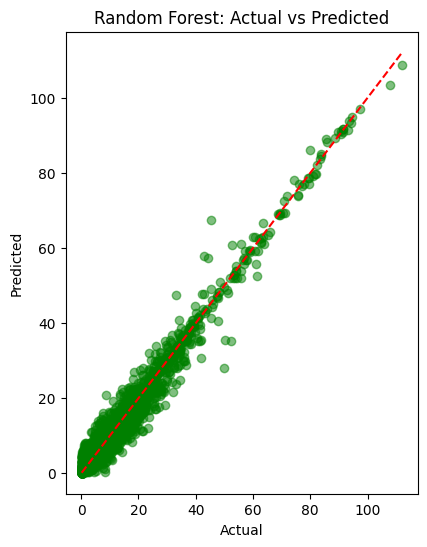

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost: Actual vs Predicted')

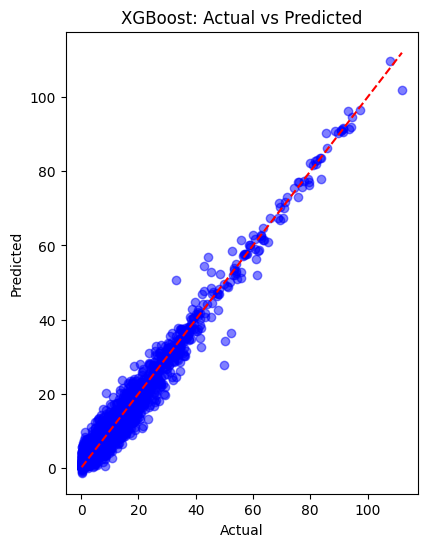

In [70]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")

In [71]:
#Validation performance

rf_val = rf.predict(X_val)

xgb_val = xgb.predict(X_val)

evaluate_model("Random Forrest", y_val, rf_val)
evaluate_model("XGBoost", y_val, xgb_val )


Random Forrest Performance:
MAE: 2.5425374310431867
RMSE: 6.229122059529682
R2 Score: 0.8146986655007404

XGBoost Performance:
MAE: 2.50353218424753
RMSE: 6.213351797406876
R2 Score: 0.8156357322203768


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest Validation: Actual vs Predicted')

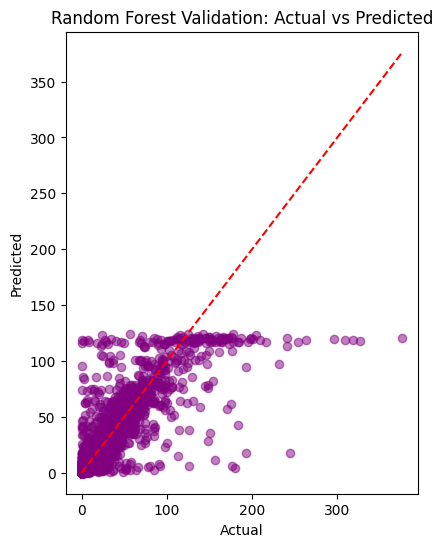

In [72]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, rf_val, alpha=0.5, color='purple')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Validation: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost Validation: Actual vs Predicted')

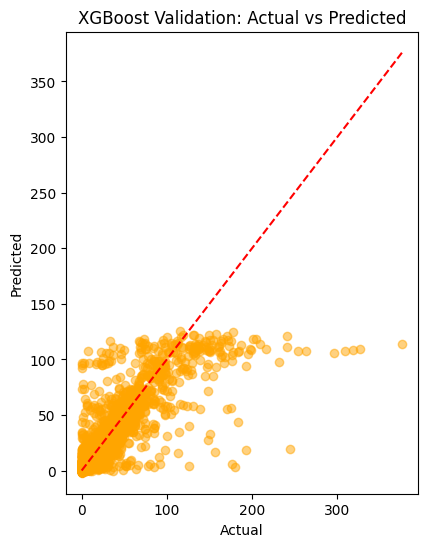

In [73]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, xgb_val, alpha=0.5, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Validation: Actual vs Predicted")

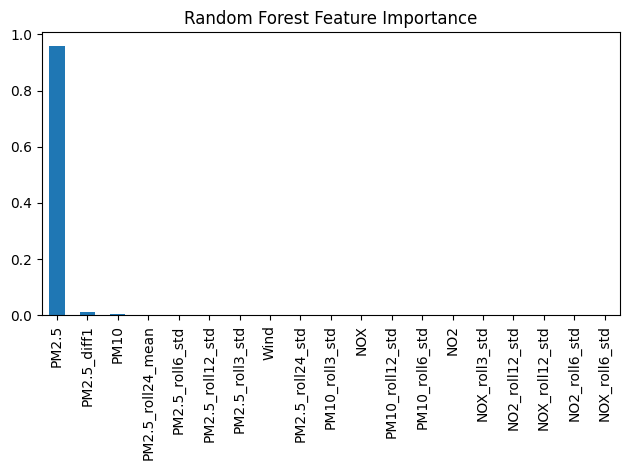

In [74]:
import matplotlib.pyplot as plt

# For Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_importance.plot(kind='bar', title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()




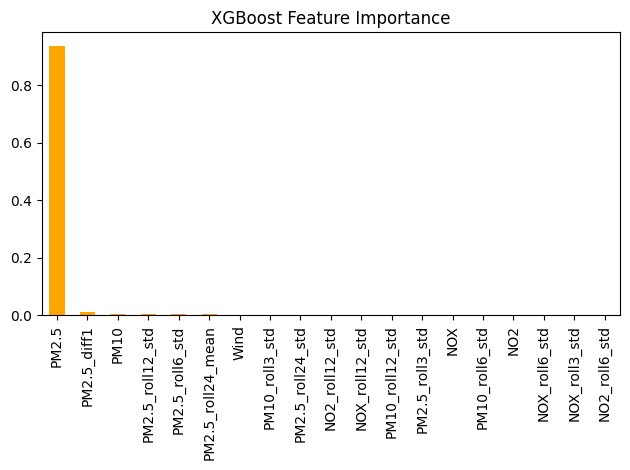

In [75]:
# For XGBoost
xgb_importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance.plot(kind='bar', title='XGBoost Feature Importance', color='orange')
plt.tight_layout()
plt.show()